# **FINAL CM KELOMPOK 7**

## **[1] Preparation**

### **Importing Libraries**

In [3]:
!pip install mediapipe

# Core libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
import os
from tqdm import tqdm
import pickle
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

# MediaPipe for face detection
import mediapipe as mp

# Scikit-learn for ML pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay
)

# Scikit-image for LBP
from skimage.feature import local_binary_pattern

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ All libraries imported successfully!")
print(f"OpenCV version: {cv2.__version__}")
print(f"MediaPipe version: {mp.__version__}")

✓ All libraries imported successfully!
OpenCV version: 4.11.0
MediaPipe version: 0.10.21


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Project Configurations**

In [5]:
CONFIG = {
    'DATASET_SOURCES': {
        'masked': Path('/content/drive/MyDrive/Campus/PCVK_5/IMAGES/PBL/PRIMARY/MASKED'),
        'unmasked': Path('/content/drive/MyDrive/Campus/PCVK_5/IMAGES/PBL/PRIMARY/UNMASKED'),
    },
    'DATASET_LIMIT': 100,
    'USE_BOTH_SOURCES': True,
    'MODEL_PATH': Path('models'),
    'FACE_DETECTION_CONFIDENCE': 0.5,
    'EYE_ROI_TARGET_SIZE': (96, 32),
    'NEIGHBORS': 12,
}

# Create directories
CONFIG['MODEL_PATH'].mkdir(parents=True, exist_ok=True)

# Eye landmark indices
LEFT_EYE_INDICES = [33, 133, 160, 159, 158, 157, 173]  # Left eye contour
RIGHT_EYE_INDICES = [362, 263, 387, 386, 385, 384, 398]  # Right eye contour

FACE_OVAL_INDICES = [
    10, 338, 297, 332, 284, 251, 389, 356, 454,
    323, 361, 288, 397, 365, 379, 378, 400, 377,
    152, 148, 176, 149, 150, 136, 172, 58, 132,
    93, 234, 127, 162, 21, 54, 103, 67, 109
]


# Initialize MediaPipe Face Mesh (global)
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=CONFIG['FACE_DETECTION_CONFIDENCE']
)

print("✓ Configuration loaded!")
print(f"Dataset sources:")
for name, path in CONFIG['DATASET_SOURCES'].items():
    print(f"  {name}: {path}")
print(f"Use both sources: {CONFIG['USE_BOTH_SOURCES']}")

✓ Configuration loaded!
Dataset sources:
  masked: /content/drive/MyDrive/Campus/PCVK_5/IMAGES/PBL/PRIMARY/MASKED
  unmasked: /content/drive/MyDrive/Campus/PCVK_5/IMAGES/PBL/PRIMARY/UNMASKED
Use both sources: True


### **Helper Functions**

In [6]:
def log(msg):
    """Logging with timestamps"""
    from datetime import datetime
    timestamp = datetime.now().strftime("%H:%M:%S")
    print(f"[{timestamp}] {msg}")

def showSideBySide(titles, images, cmap=None, figsize=(14, 7)):
    """Display multiple images side by side with proper formatting"""
    plt.figure(figsize=figsize)
    for i in range(len(titles)):
        plt.subplot(1, len(titles), i+1)
        plt.imshow(images[i], cmap=cmap)
        plt.title(titles[i], fontsize=12, fontweight='bold')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def showGrid(titles, images, rows=2, cols=5, figsize=(15, 6)):
    """Display images in a grid layout"""
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, (ax, img) in enumerate(zip(axes, images)):
        if img is not None:
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if len(img.shape) == 3 else img, cmap='gray')
            if titles and i < len(titles):
                ax.set_title(titles[i], fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def plot_class_distribution(labels, label_to_id, top_n=20):
    """Plot distribution of samples per class"""
    id_to_label = {v: k for k, v in label_to_id.items()}
    label_names = [id_to_label[l] for l in labels]

    from collections import Counter
    counts = Counter(label_names)

    # Get top N classes
    top_classes = counts.most_common(top_n)
    names, values = zip(*top_classes)

    plt.figure(figsize=(14, 6))
    bars = plt.bar(range(len(names)), values, color='steelblue', edgecolor='black', alpha=0.7)
    plt.xlabel('Person', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
    plt.title(f'Top {top_n} Classes by Sample Count (Total: {len(label_to_id)} classes)',
              fontsize=14, fontweight='bold')
    plt.xticks(range(len(names)), names, rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

    print(f"Total samples: {len(labels)}")
    print(f"Total classes: {len(label_to_id)}")
    print(f"Average samples per class: {len(labels)/len(label_to_id):.2f}")

def visualize_feature_samples(images, labels, label_to_id, n_samples=10):
    """Visualize random samples from dataset"""
    id_to_label = {v: k for k, v in label_to_id.items()}

    # Random sample indices
    indices = np.random.choice(len(images), min(n_samples, len(images)), replace=False)

    rows = 2
    cols = 5
    fig, axes = plt.subplots(rows, cols, figsize=(16, 7))
    axes = axes.flatten()

    for idx, ax in enumerate(axes):
        if idx < len(indices):
            img_idx = indices[idx]
            img = images[img_idx]
            label_id = labels[img_idx]
            person_name = id_to_label[label_id]

            if len(img.shape) == 3:
                ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            else:
                ax.imshow(img, cmap='gray')

            ax.set_title(f"{person_name[:20]}", fontsize=10, fontweight='bold')
        ax.axis('off')

    plt.suptitle('Random Sample Images from Dataset', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix_enhanced(y_true, y_pred, label_to_id, top_n=15):
    """Plot enhanced confusion matrix for top N classes"""
    id_to_label = {v: k for k, v in label_to_id.items()}

    # Get top N most common classes
    from collections import Counter
    class_counts = Counter(y_true)
    top_classes = [cls for cls, _ in class_counts.most_common(top_n)]

    # Filter predictions for top classes
    mask = np.isin(y_true, top_classes)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

    # Create confusion matrix
    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=top_classes)

    # Normalize
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=[id_to_label[i][:15] for i in top_classes],
                yticklabels=[id_to_label[i][:15] for i in top_classes],
                cbar_kws={'label': 'Accuracy'})
    plt.title(f'Normalized Confusion Matrix (Top {top_n} Classes)',
              fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_feature_dimensionality(features_original, features_reduced, variance_explained=None):
    """Visualize feature dimensionality before and after reduction"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Original features
    axes[0].bar(['Original Features'], [features_original.shape[1]],
                color='coral', edgecolor='black', alpha=0.7, width=0.4)
    axes[0].set_ylabel('Number of Features', fontsize=12, fontweight='bold')
    axes[0].set_title('Original Feature Dimension', fontsize=12, fontweight='bold')
    axes[0].text(0, features_original.shape[1], f'{features_original.shape[1]}',
                ha='center', va='bottom', fontsize=14, fontweight='bold')
    axes[0].set_ylim(0, features_original.shape[1] * 1.2)

    # Reduced features
    axes[1].bar(['Reduced Features'], [features_reduced.shape[1]],
                color='steelblue', edgecolor='black', alpha=0.7, width=0.4)
    axes[1].set_ylabel('Number of Features', fontsize=12, fontweight='bold')
    axes[1].set_title('Reduced Feature Dimension', fontsize=12, fontweight='bold')
    axes[1].text(0, features_reduced.shape[1], f'{features_reduced.shape[1]}',
                ha='center', va='bottom', fontsize=14, fontweight='bold')
    axes[1].set_ylim(0, features_original.shape[1] * 1.2)

    if variance_explained is not None:
        axes[1].text(0, features_reduced.shape[1] * 0.5,
                    f'Variance: {variance_explained:.1%}',
                    ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()

print("✓ Helper and visualization functions defined!")

✓ Helper and visualization functions defined!


## **[2] Loading Dataset**

In [7]:
def load_dataset(dataset_sources, use_both=True, limit=50):
    sources_to_load = ['masked']
    if use_both and 'unmasked' in dataset_sources:
        sources_to_load.append('unmasked')

    log(f"Loading from sources: {sources_to_load}")

    person_images = {}

    for source_name in sources_to_load:
        if source_name not in dataset_sources:
            continue

        source_path = Path(dataset_sources[source_name])

        if not source_path.exists():
            log(f"⚠ Warning: {source_name} path does not exist: {source_path}")
            continue

        log(f"\nScanning {source_name}: {source_path}")

        person_folders = sorted([d for d in source_path.iterdir() if d.is_dir()])
        log(f"  Found {len(person_folders)} person folders")

        for person_dir in person_folders:
            person_name = person_dir.name

            image_files = list(person_dir.glob('*.jpg')) + \
                          list(person_dir.glob('*.png')) + \
                          list(person_dir.glob('*.jpeg'))

            # Batasi hanya 50 gambar per folder
            image_files = image_files[:limit]

            if person_name not in person_images:
                person_images[person_name] = []

            person_images[person_name].extend(image_files)

    # Label mapping
    label_to_id = {name: idx for idx, name in enumerate(sorted(person_images.keys()))}

    # Flatten
    all_image_paths = []
    all_labels = []

    for person_name, img_paths in person_images.items():
        label_id = label_to_id[person_name]
        for img_path in img_paths:
            all_image_paths.append(img_path)
            all_labels.append(label_id)

    return all_image_paths, all_labels, label_to_id

## **[3] Face Detection, Alignment, and Upper Face Extraction**

In [8]:
def get_eye_center(landmarks, image_shape, eye_indices):
    h, w = image_shape[:2]
    pts = []

    for idx in eye_indices:
        x = int(landmarks[idx].x * w)
        y = int(landmarks[idx].y * h)
        pts.append([x, y])

    pts = np.array(pts)
    center = np.mean(pts, axis=0)

    return np.array([int(center[0]), int(center[1])])

def crop_eye_roi(image, landmarks):
    h, w = image.shape[:2]
    pts = np.array([[int(l.x * w), int(l.y * h)] for l in landmarks])

    # Get eye landmark points
    left_eye_pts = pts[LEFT_EYE_INDICES]
    right_eye_pts = pts[RIGHT_EYE_INDICES]

    # Combine both eyes
    eyes = np.vstack([left_eye_pts, right_eye_pts])

    # Bounding box around eye region
    x_min, y_min = eyes.min(axis=0)
    x_max, y_max = eyes.max(axis=0)

    # Add margin around eyes
    margin_x = int((x_max - x_min) * 0.1)
    margin_y = int((y_max - y_min) * 1.75)

    x_min = max(0, x_min - margin_x)
    y_min = max(0, y_min - margin_y)
    x_max = min(w, x_max + margin_x)
    y_max = min(h, y_max + margin_y)

    # Crop eye ROI
    eye_crop = image[y_min:y_max, x_min:x_max]

    if eye_crop.size == 0:
        return None

    return eye_crop

In [9]:
def face_detection_pipeline(image_path):
    # Load image
    image = cv2.imread(str(image_path))
    if image is None:
        return None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detect face
    results = face_mesh.process(image_rgb)

    if not results.multi_face_landmarks:
        return None

    landmarks = results.multi_face_landmarks[0].landmark

    # Get eye centers
    left_eye = get_eye_center(landmarks, image.shape, LEFT_EYE_INDICES)
    right_eye = get_eye_center(landmarks, image.shape, RIGHT_EYE_INDICES)

    # Calculate rotation angle from eye positions
    dy = right_eye[1] - left_eye[1]
    dx = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dy, dx))

    # Align face only if necessary
    if abs(angle) > 2.0:
        h, w = image.shape[:2]
        eye_center = (
            float((left_eye[0] + right_eye[0]) / 2),
            float((left_eye[1] + right_eye[1]) / 2)
        )

        M = cv2.getRotationMatrix2D(eye_center, angle, 1.0)

        aligned = cv2.warpAffine(
            image, M,
            (w, h),
            flags=cv2.INTER_CUBIC
        )

        # Transform landmarks using affine matrix
        aligned_landmarks = []
        for lm in landmarks:
            x = lm.x * w
            y = lm.y * h
            new_x = M[0, 0] * x + M[0, 1] * y + M[0, 2]
            new_y = M[1, 0] * x + M[1, 1] * y + M[1, 2]

            # Create simple object with x, y attributes (normalized)
            aligned_lm = type('Landmark', (), {
                'x': new_x / w,
                'y': new_y / h
            })()
            aligned_landmarks.append(aligned_lm)

        landmarks = aligned_landmarks
    else:
        aligned = image

    # Crop eye roi
    eye_roi_image = crop_eye_roi(aligned, landmarks)

    return eye_roi_image

## **[4] Preprocessing**

In [10]:
def preprocessing_pipeline(eye_roi_image, target_size=(160, 160)):
    # Resize
    resized_image = cv2.resize(eye_roi_image, target_size, interpolation=cv2.INTER_CUBIC)

    # Grayscale
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # CLAHE instead of simple histogram equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(gray_image)

    # Optional: Gaussian blur to reduce noise
    denoised_image = cv2.GaussianBlur(enhanced_image, (3, 3), 0)

    return denoised_image

In [11]:
def augmenting_pipeline(image, n_aug=8):  # Increase to 8
    augmented = [image]
    h, w = image.shape

    for _ in range(n_aug):
        aug = image.copy()

        # 1. More aggressive brightness variation
        brightness = np.random.uniform(-40, 40)  # Increased range
        aug = np.clip(aug.astype(np.float32) + brightness, 0, 255).astype(np.uint8)

        # 2. Contrast adjustment
        alpha = np.random.uniform(0.8, 1.2)
        aug = np.clip(alpha * aug, 0, 255).astype(np.uint8)

        # 3. Add noise occasionally
        if np.random.rand() > 0.7:
            noise = np.random.normal(0, 5, aug.shape)
            aug = np.clip(aug + noise, 0, 255).astype(np.uint8)

        # 4. Gaussian blur
        if np.random.rand() > 0.6:  # More frequent
            aug = cv2.GaussianBlur(aug, (3, 3), 0)

        # 5. Horizontal flip (valid for eyes)
        if np.random.rand() > 0.5:
            aug = cv2.flip(aug, 1)

        # 6. Small rotations
        angle = np.random.uniform(-5, 5)
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
        aug = cv2.warpAffine(aug, M, (w, h), borderMode=cv2.BORDER_REFLECT)

        # 7. Scale & translate
        scale = np.random.uniform(0.92, 1.08)
        M2 = np.array([[scale, 0, np.random.uniform(-5, 5)],
                       [0, scale, np.random.uniform(-5, 5)]], dtype=np.float32)
        aug = cv2.warpAffine(aug, M2, (w, h), borderMode=cv2.BORDER_REFLECT)

        augmented.append(aug)

    return augmented

## **[5] Feature Extraction**

In [12]:
def feature_extraction_pipeline(equalized_image, grid_size=(4, 4)):
    """Extract multi-scale LBP features"""
    features_list = []

    # Multiple radius/points combinations
    lbp_configs = [
        (1, 8),   # Fine details
        (2, 16),  # Medium details
        (3, 24),  # Coarse details
    ]

    for radius, n_points in lbp_configs:
        n_bins = n_points + 2
        lbp = local_binary_pattern(equalized_image, n_points, radius, method='uniform')

        h, w = equalized_image.shape
        grid_y, grid_x = grid_size
        cell_h, cell_w = h // grid_y, w // grid_x

        cell_features = []

        for gy in range(grid_y):
            for gx in range(grid_x):
                y0, y1 = gy * cell_h, (gy + 1) * cell_h if gy < grid_y - 1 else h
                x0, x1 = gx * cell_w, (gx + 1) * cell_w if gx < grid_x - 1 else w

                cell_lbp = lbp[y0:y1, x0:x1]
                hist, _ = np.histogram(cell_lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

                # L2 normalization
                norm = np.linalg.norm(hist)
                if norm > 1e-7:
                    hist = hist / norm

                cell_features.append(hist)

        features_list.append(np.concatenate(cell_features))

    # Concatenate all scales
    return np.concatenate(features_list)

## **[6] Classification**

In [13]:
def knn_fit(X_train, y_train, k=5, metric="cosine", weights="distance"):
    """Train KNN classifier with specified parameters"""
    knn = KNeighborsClassifier(n_neighbors=k, metric=metric, weights=weights)
    knn.fit(X_train, y_train)

    train_score = knn.score(X_train, y_train)
    print(f"KNN Training Score: {train_score:.4f}")
    return knn

def knn_predict(knn, X):
    """Predict labels using trained KNN model"""
    y_pred = knn.predict(X)
    return y_pred

def evaluate_knn(knn, X_test, y_test, label_to_id):
    """Comprehensive evaluation of KNN model"""
    y_pred = knn.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)

    print("=" * 60)
    print("KNN MODEL EVALUATION")
    print("=" * 60)
    print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print("-" * 60)

    # Classification report for top classes
    id_to_label = {v: k for k, v in label_to_id.items()}
    target_names = [id_to_label[i] for i in sorted(set(y_test))]

    print("\nClassification Report (sample):")
    print(classification_report(y_test, y_pred, target_names=target_names,
                                labels=sorted(set(y_test))[:10], zero_division=0))

    return accuracy, y_pred

def cross_validate_knn(X, y, k=5, cv=5):
    """Perform cross-validation on KNN model"""
    log(f"Performing {cv}-fold cross-validation...")

    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine', weights='distance')
    scores = cross_val_score(knn, X, y, cv=cv, scoring='accuracy')

    print(f"\nCross-Validation Scores: {scores}")
    print(f"Mean CV Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

    return scores

print("✓ Classification functions defined!")

✓ Classification functions defined!


## **[STAR] Main Pipeline**

In [14]:
def process_dataset(image_paths, labels):
    log("STEP 02 & 03: Face Detection → Preprocessing → Augmentation")

    processed_images = []
    processed_labels = []

    for idx, image_path in enumerate(tqdm(image_paths, desc="Processing Dataset")):
        # --- Face Detection ---
        eye_roi_image = face_detection_pipeline(image_path)
        if eye_roi_image is None:
            continue  # Skip kalau gagal deteksi

        # --- Preprocessing ---
        equalized_image = preprocessing_pipeline(eye_roi_image, target_size=CONFIG['EYE_ROI_TARGET_SIZE'])

        # --- Augmentasi ---
        augmented = augmenting_pipeline(equalized_image)

        # Append semua hasil augmentasi
        label = labels[idx]
        processed_images.extend(augmented)
        processed_labels.extend([label] * len(augmented))

    log(f"✓ Done! Processed {len(processed_images)} images total.")
    return processed_images, processed_labels

In [15]:
log("STEP 01: Loading Dataset")
image_paths, labels, label_to_id = load_dataset(CONFIG['DATASET_SOURCES'], CONFIG['USE_BOTH_SOURCES'], CONFIG['DATASET_LIMIT'])
log("✓ Done!")

[23:46:57] STEP 01: Loading Dataset
[23:46:57] Loading from sources: ['masked', 'unmasked']
[23:47:10] 
Scanning masked: /content/drive/MyDrive/Campus/PCVK_5/IMAGES/PBL/PRIMARY/MASKED
[23:47:11]   Found 24 person folders
[23:47:17] 
Scanning unmasked: /content/drive/MyDrive/Campus/PCVK_5/IMAGES/PBL/PRIMARY/UNMASKED
[23:47:17]   Found 24 person folders
[23:47:24] ✓ Done!


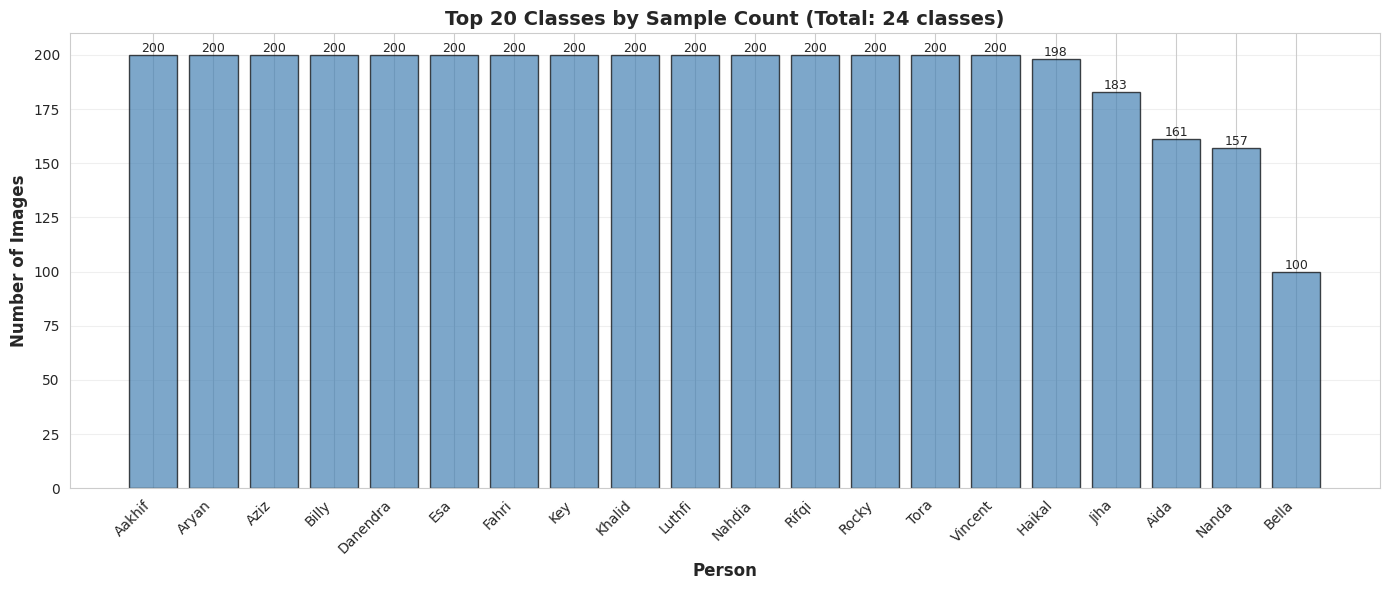

Total samples: 4151
Total classes: 24
Average samples per class: 172.96


In [16]:
plot_class_distribution(labels, label_to_id, top_n=20)

In [17]:
log("STEP 02 & 03: Processing Dataset")
processed_images, labels = process_dataset(image_paths, labels)
log("✓ All Face Detection, Preprocessing, and Augmentation Completed!")

[23:47:25] STEP 02 & 03: Processing Dataset
[23:47:25] STEP 02 & 03: Face Detection → Preprocessing → Augmentation


Processing Dataset: 100%|██████████| 4151/4151 [40:04<00:00,  1.73it/s]

[00:27:29] ✓ Done! Processed 37206 images total.
[00:27:29] ✓ All Face Detection, Preprocessing, and Augmentation Completed!


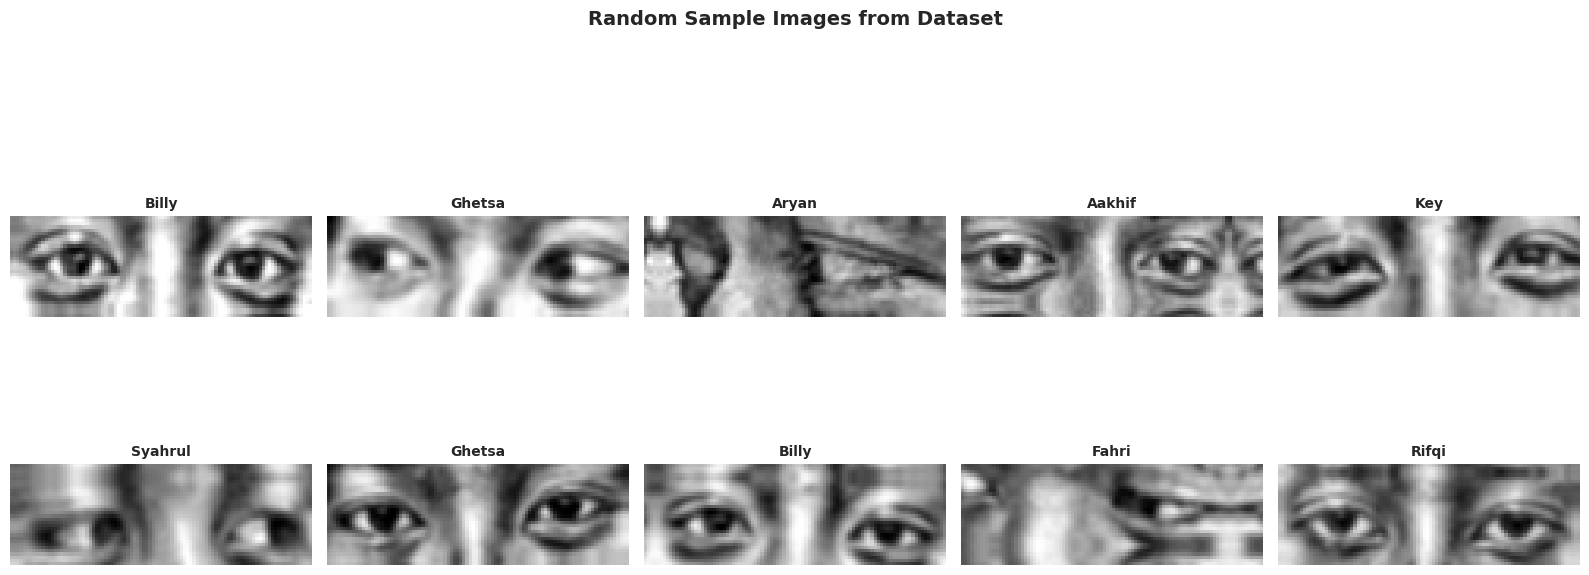

In [18]:
visualize_feature_samples(processed_images, labels, label_to_id, n_samples=10)

In [19]:
log("STEP 04: Feature Extraction")
features = []
for processed_image in tqdm(processed_images, desc="Extracting Features"):
    feature = feature_extraction_pipeline(processed_image)
    features.append(feature)

features = np.array(features)  # Convert to numpy array
log(f"✓ Done! Feature shape: {features.shape}")

[00:27:30] STEP 04: Feature Extraction


Extracting Features: 100%|██████████| 37206/37206 [08:06<00:00, 76.51it/s]


[00:35:37] ✓ Done! Feature shape: (37206, 864)


[00:35:37] STEP 05: Classification
[00:35:41] Original feature dimension: 864
[00:35:41] Reduced feature dimension: 610
[00:35:41] Variance explained: 95.02%


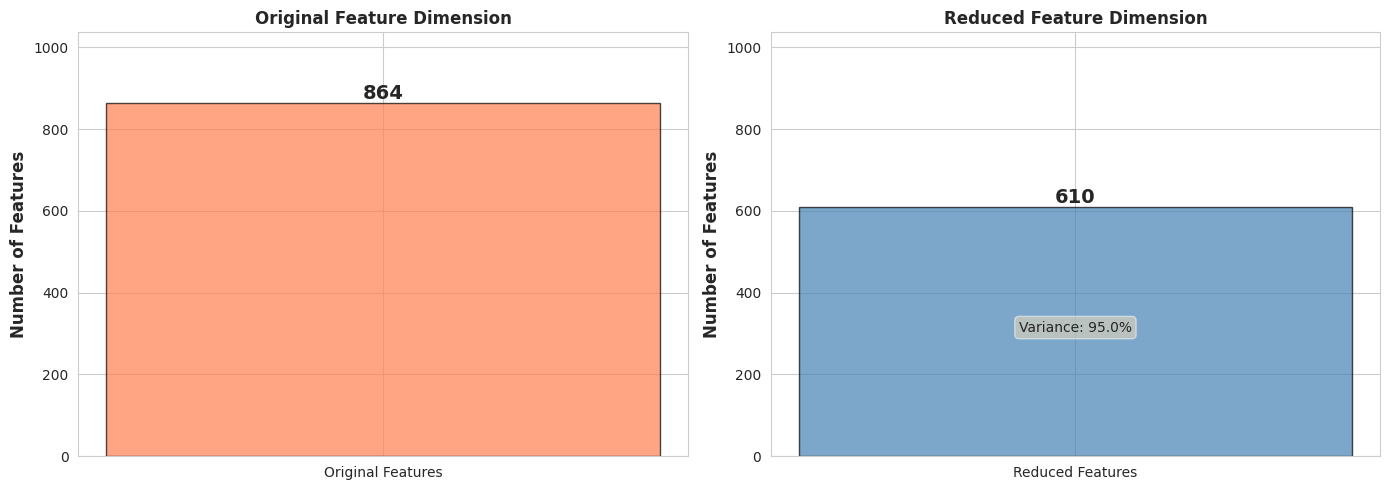

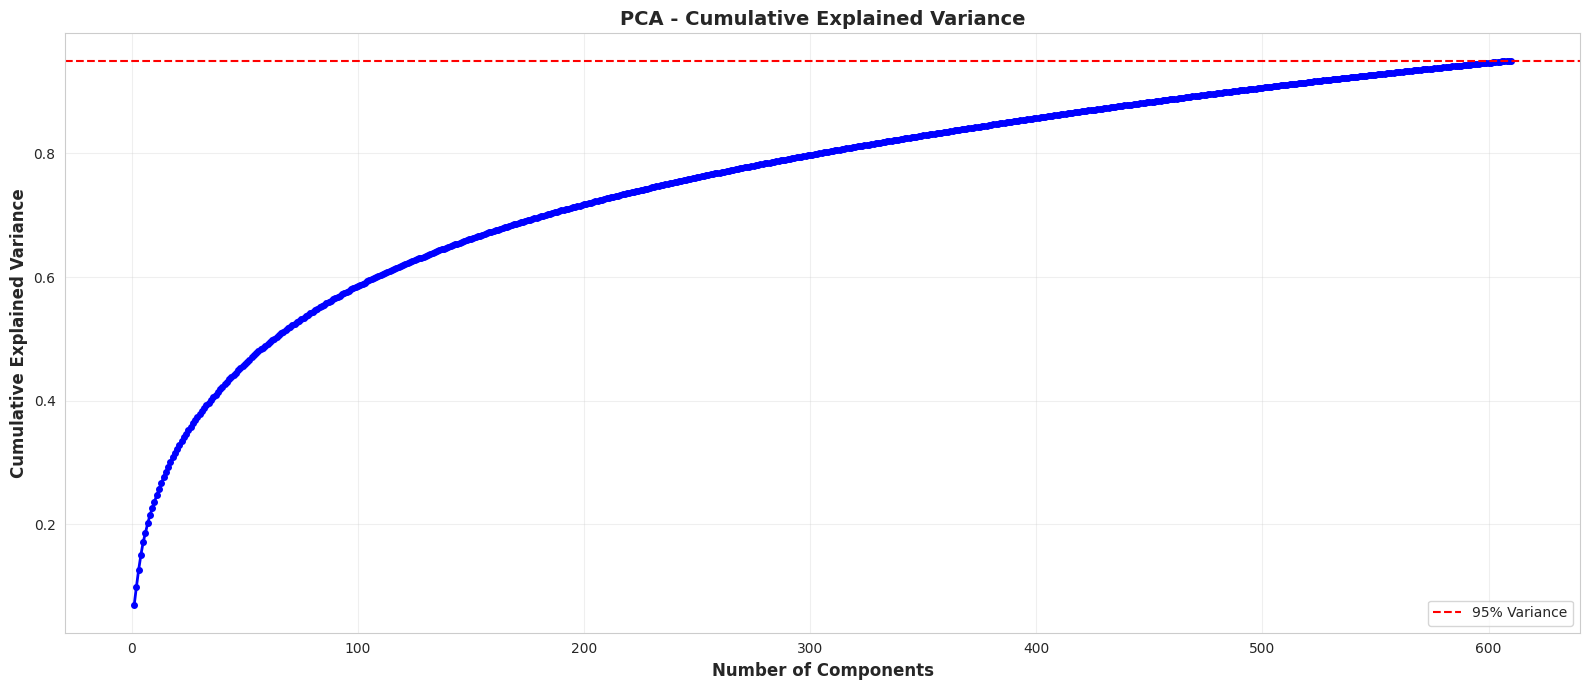

[00:35:41] Performing 5-fold cross-validation...

Cross-Validation Scores: [0.90828154 0.90055434 0.90391399 0.90324206 0.90658602]
Mean CV Accuracy: 0.9045 (+/- 0.0054)
KNN Training Score: 1.0000
KNN MODEL EVALUATION
Test Accuracy: 0.9144 (91.44%)
------------------------------------------------------------

Classification Report (sample):
              precision    recall  f1-score   support

      Aakhif       0.91      0.97      0.94       368
        Aida       0.93      0.88      0.91       295
       Aryan       0.86      0.84      0.85       334
        Aziz       0.90      0.91      0.90       380
       Bella       0.96      0.72      0.82       179
       Billy       0.93      0.92      0.93       372
    Danendra       0.97      0.91      0.94       342
         Esa       0.95      0.88      0.91       368
       Fahri       0.91      0.97      0.94       366
      Ghetsa       0.92      0.93      0.92       168

   micro avg       0.92      0.90      0.91      3172
   macr

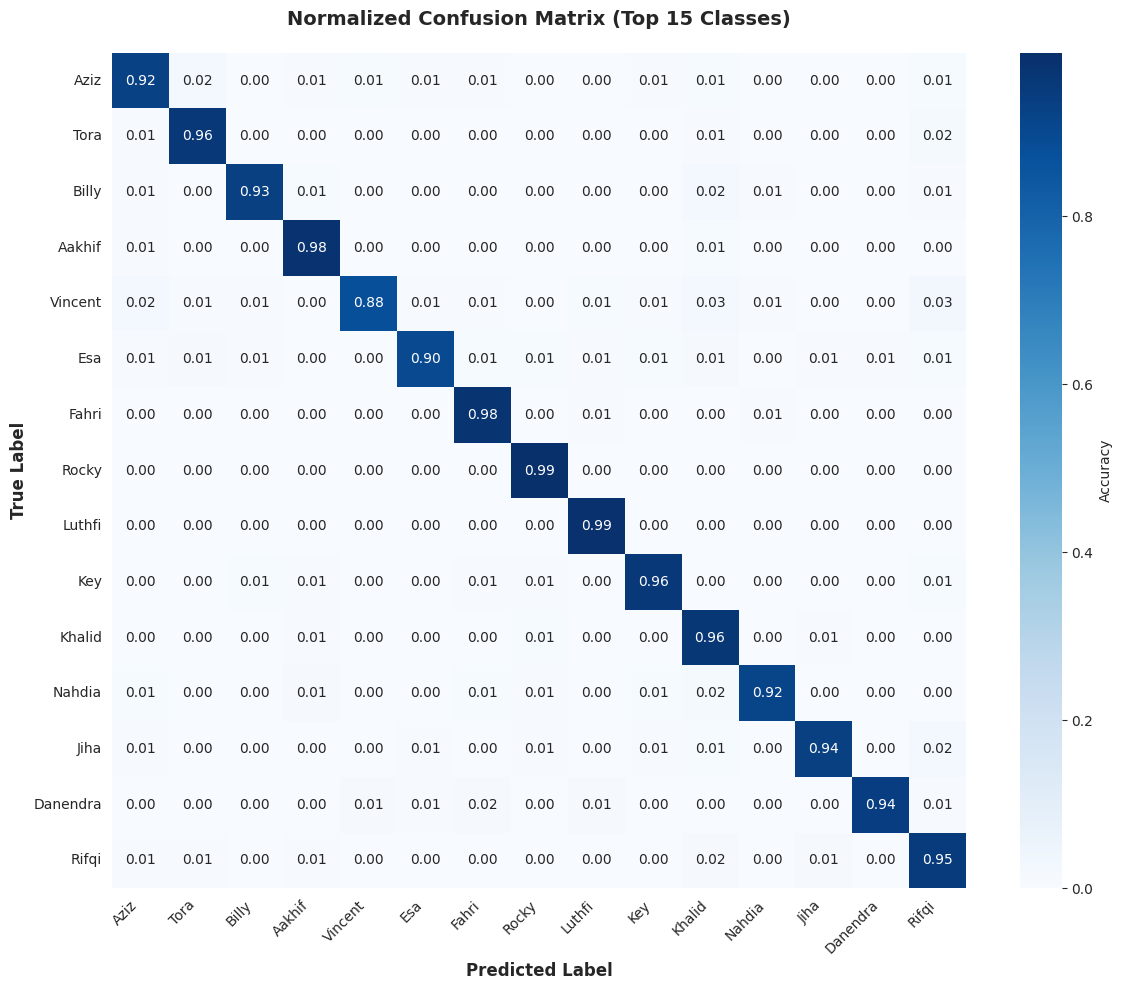

[00:37:55] ✓ Done!


In [20]:
log("STEP 05: Classification")

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# PCA
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

variance_explained = np.sum(pca.explained_variance_ratio_)

log(f"Original feature dimension: {X_train.shape[1]}")
log(f"Reduced feature dimension: {X_train_pca.shape[1]}")
log(f"Variance explained: {variance_explained:.2%}")

# Visualize dimensionality reduction
plot_feature_dimensionality(X_train, X_train_pca, variance_explained)

# Plot cumulative explained variance
plt.figure(figsize=(16, 7))
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumsum) + 1), cumsum, 'b-o', linewidth=2, markersize=4)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.xlabel('Number of Components', fontsize=12, fontweight='bold')
plt.ylabel('Cumulative Explained Variance', fontsize=12, fontweight='bold')
plt.title('PCA - Cumulative Explained Variance', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Cross-validation on training set
cv_scores = cross_validate_knn(X_train_pca, y_train, k=CONFIG['NEIGHBORS'], cv=5)

# Train the model
knn = knn_fit(X_train_pca, y_train, k=CONFIG['NEIGHBORS'], metric='cosine', weights='distance')

# Evaluate the model
test_accuracy, y_pred = evaluate_knn(knn, X_test_pca, y_test, label_to_id)
plot_confusion_matrix_enhanced(y_test, y_pred, label_to_id, top_n=15)
log("✓ Done!")

In [21]:
# Save the trained model and label mapping
log("Saving model and label mapping...")

model_data = {
    'knn_model': knn,
    'pca': pca,
    'scaler': scaler,
    'label_to_id': label_to_id,
    'config': {
        'k': CONFIG['NEIGHBORS'],
        'metric': 'cosine',
        'weights': 'distance',
        'feature_dim_original': X_train.shape[1],
        'feature_dim_pca': X_train_pca.shape[1],
        'variance_explained': variance_explained,
        'test_accuracy': test_accuracy
    }
}

with open(CONFIG['MODEL_PATH'] / 'knn_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

log("✓ Model saved successfully!")
log(f"  File: {CONFIG['MODEL_PATH'] / 'knn_model.pkl'}")
log(f"  Test Accuracy: {test_accuracy:.4f}")

[00:37:55] Saving model and label mapping...
[00:37:56] ✓ Model saved successfully!
[00:37:56]   File: models/knn_model.pkl
[00:37:56]   Test Accuracy: 0.9144


In [22]:
log("STEP 06: Inference")
image_test_path = "vincent_test.jpg"
eye_roi_image_test = face_detection_pipeline(image_test_path)

if eye_roi_image_test is None:
    print("❌ Failed to detect face in test image!")
else:
    # Read original image for display
    image_test = cv2.imread(image_test_path)

    equalized_image_test = preprocessing_pipeline(eye_roi_image_test, CONFIG['EYE_ROI_TARGET_SIZE'])

    showSideBySide(
        ['Original', 'Upper Face', 'Equalized'],
        [cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB),
         cv2.cvtColor(eye_roi_image_test, cv2.COLOR_BGR2RGB),
         equalized_image_test],
        cmap='gray'
    )

    feature_test = feature_extraction_pipeline(equalized_image_test)
    feature_test = feature_test.reshape(1, -1)  # Reshape for single prediction

    feature_test = scaler.transform(feature_test)

    # Apply PCA transformation
    feature_test_pca = pca.transform(feature_test)

    print(f"Original feature shape: {feature_test.shape}")
    print(f"PCA feature shape: {feature_test_pca.shape}")

    # Ambil nama file tanpa ekstensi
    base_name = os.path.splitext(os.path.basename(image_test_path))[0]

    # Save LBP
    np.savetxt(
        f"{base_name}_lbp.csv",
        feature_test.reshape(1, -1),
        delimiter=",",
        fmt="%.6f"
    )

    # Save PCA
    np.savetxt(
        f"{base_name}_pca.csv",
        feature_test_pca.reshape(1, -1),
        delimiter=",",
        fmt="%.6f"
    )

    prediction = knn_predict(knn, feature_test_pca)

    try:
        probabilities = knn.predict_proba(feature_test_pca)
        confidence = np.max(probabilities)
        top_5_indices = np.argsort(probabilities[0])[-5:][::-1]

        print("\nTop 5 Predictions:")
        id_to_label = {v: k for k, v in label_to_id.items()}
        for i, idx in enumerate(top_5_indices, 1):
            print(f"  {i}. {id_to_label[idx]}: {probabilities[0][idx]:.4f}")
    except:
        confidence = 1.0

    # Get person name from label
    id_to_label = {v: k for k, v in label_to_id.items()}
    predicted_person = id_to_label[prediction[0]]

    print(f"✓ Predicted: {predicted_person}")

log("✓ Done!")

[00:37:56] STEP 06: Inference
❌ Failed to detect face in test image!
[00:37:57] ✓ Done!


## **[STAR] Inference Pipeline**

In [23]:
def load_trained_model(model_path):
    with open(model_path, 'rb') as f:
        model_data = pickle.load(f)

    log(f"✓ Model loaded successfully!")
    log(f"  Original feature dimension: {model_data['config']['feature_dim_original']}")
    log(f"  PCA feature dimension: {model_data['config']['feature_dim_pca']}")
    log(f"  Number of classes: {len(model_data['label_to_id'])}")
    log(f"  Test accuracy: {model_data['config']['test_accuracy']:.4f}")

    return model_data['knn_model'], model_data['pca'], model_data['scaler'], model_data['label_to_id']

In [24]:
def inference_pipeline(image_path, knn_model, pca, scaler, label_to_id):
    """Complete inference pipeline with PCA transformation"""
    # Step 1: Face detection and alignment
    eye_roi_image = face_detection_pipeline(image_path)

    if eye_roi_image is None:
        return None, 0.0, None

    # Step 2: Preprocessing
    equalized_image = preprocessing_pipeline(eye_roi_image, CONFIG['EYE_ROI_TARGET_SIZE'])

    # Step 3: Feature extraction
    features = feature_extraction_pipeline(equalized_image)
    features = features.reshape(1, -1)
    features = scaler.transform(features)

    # Step 4: PCA transformation
    features_pca = pca.transform(features)

    # Step 5: Prediction
    prediction = knn_model.predict(features_pca)

    # Get prediction probabilities
    try:
        probabilities = knn_model.predict_proba(features_pca)
        confidence = np.max(probabilities)
        top_5_indices = np.argsort(probabilities[0])[-5:][::-1]
        top_5_predictions = [(idx, probabilities[0][idx]) for idx in top_5_indices]
    except:
        confidence = 1.0
        top_5_predictions = None

    # Convert ID to person name
    id_to_label = {v: k for k, v in label_to_id.items()}
    predicted_person = id_to_label[prediction[0]]

    return predicted_person, confidence, top_5_predictions

print("✓ Inference pipeline function defined!")

✓ Inference pipeline function defined!


In [25]:
# Example usage of inference pipeline
test_image_path = "esa_test.jpg"

predicted_person, confidence, top_5 = inference_pipeline(test_image_path, knn, pca, scaler, label_to_id)

if predicted_person:
    print(f"✓ Predicted Person: {predicted_person}")
    print(f"  Confidence: {confidence:.2%}")

    if top_5:
        print("\nTop 5 Predictions:")
        id_to_label = {v: k for k, v in label_to_id.items()}
        for i, (idx, prob) in enumerate(top_5, 1):
            print(f"  {i}. {id_to_label[idx]}: {prob:.2%}")

    # Display the test image with prediction
    test_img = cv2.imread(test_image_path)
    if test_img is not None:
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Predicted: {predicted_person}\nConfidence: {confidence:.2%}",
                  fontsize=16, fontweight='bold',
                  bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
        plt.axis('off')
        plt.tight_layout()
        plt.show()
else:
    print("❌ Failed to detect face in the test image!")

❌ Failed to detect face in the test image!
